# Basic RNN for predicting what country a name is from

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

# Preprocessing

Ripped from pytorch: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [24]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the dictionary dictionary, a list of names per language
dictionary = {}
all_countries = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_countries.append(category)
    lines = readLines(filename)
    dictionary[category] = lines

n_countries = len(all_countries)

['names/Czech.txt', 'names/German.txt', 'names/Arabic.txt', 'names/Japanese.txt', 'names/Chinese.txt', 'names/Vietnamese.txt', 'names/Russian.txt', 'names/French.txt', 'names/Irish.txt', 'names/English.txt', 'names/Spanish.txt', 'names/Greek.txt', 'names/Italian.txt', 'names/Portuguese.txt', 'names/Scottish.txt', 'names/Dutch.txt', 'names/Korean.txt', 'names/Polish.txt']


In [28]:
print(f"{unicodeToAscii('Ślusàrski')=}")
print(f"{dictionary['Czech'][:10]=}")
print(f"{all_countries[:10]=}")
print(f'{n_countries=}')

unicodeToAscii('Ślusàrski')='Slusarski'
dictionary['Czech'][:10]=['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova']
all_countries[:10]=['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English']
n_countries=18


In [27]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

print(line_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# RNN

In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

    def init_hidden_n(self):
        return torch.randn(1, self.hidden_size)
    

n_names_per_country = {country:len(names) for country, names in dictionary.items()}

def random_training_sample():
    i = np.random.randint(n_countries)
    country = all_countries[i]
    j = np.random.randint(n_names_per_country[country])
    country_tensor = torch.tensor([i], dtype = torch.long)
    name = dictionary[country][j]
    name_tensor = line_to_tensor(name)
    return country, name, country_tensor, name_tensor

def category_from_output(output):
    return all_countries[torch.argmax(output)]

## Training

In [39]:
rnn = RNN(n_letters, hidden_size=128, output_size=n_countries)
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor): # letters, class label
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

Iteration:100000, Progress:100.0%, Loss:2.3556, Prediction:Scottish, Correct:German

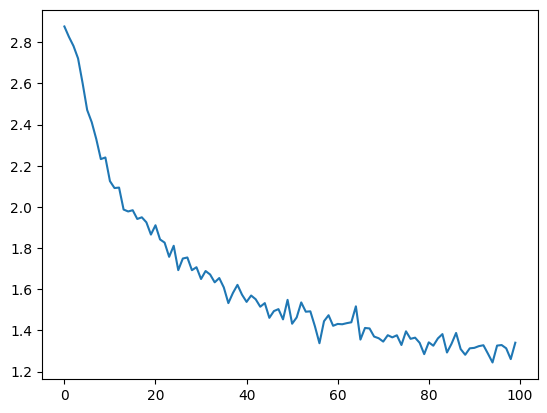

In [40]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_sample()
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        printf(f"Iteration:{i+1}, Progress:{(i+1)/n_iters * 100:.1f}%, Loss:{loss:.4f}, Prediction:{guess}, Correct:{category}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

In [58]:
def predict(new_name):
    # Prediction from RNN
    with torch.no_grad():
        rnn.eval()
        line_tensor = line_to_tensor(new_name)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        guess = category_from_output(output)
        return guess
    
names = ["Novák", "Müller", "Al-Masri", "Sato", "Wang", "Nguyen", "Smirnov", "Martin", "O'Sullivan", "Smith", "García", "Papadopoulos", "Rossi", "Silva", "MacLeod", "De Jong", "Kim", "Nowak"]
countries = ["Czech", "German", "Arabic", "Japanese", "Chinese", "Vietnamese", "Russian", "French", "Irish", "English", "Spanish", "Greek", "Italian", "Portuguese", "Scottish", "Dutch", "Korean", "Polish"]

sum_ = 0

for name, country in zip(names, countries):
    prediction = predict(unicodeToAscii(name))
    print(f"Name: {name},\tCountry: {country},\tPrediction: {prediction},\tCorrect: {country == prediction}")
    sum_ += country == prediction

# The accuracy might be bad because:
# 1. The training is random
# 2. Might need to train for longer
# 3. The name/country pairs were generated by GPT-4
print(f"Overall accuracy: {sum_ / len(names):.4f}")


Name: Novák,	Country: Czech,	Prediction: Polish,	Correct: False
Name: Müller,	Country: German,	Prediction: Scottish,	Correct: False
Name: Al-Masri,	Country: Arabic,	Prediction: Italian,	Correct: False
Name: Sato,	Country: Japanese,	Prediction: Japanese,	Correct: True
Name: Wang,	Country: Chinese,	Prediction: Chinese,	Correct: True
Name: Nguyen,	Country: Vietnamese,	Prediction: Vietnamese,	Correct: True
Name: Smirnov,	Country: Russian,	Prediction: Russian,	Correct: True
Name: Martin,	Country: French,	Prediction: Scottish,	Correct: False
Name: O'Sullivan,	Country: Irish,	Prediction: Russian,	Correct: False
Name: Smith,	Country: English,	Prediction: Scottish,	Correct: False
Name: García,	Country: Spanish,	Prediction: Portuguese,	Correct: False
Name: Papadopoulos,	Country: Greek,	Prediction: Greek,	Correct: True
Name: Rossi,	Country: Italian,	Prediction: Italian,	Correct: True
Name: Silva,	Country: Portuguese,	Prediction: Czech,	Correct: False
Name: MacLeod,	Country: Scottish,	Prediction: 